<a href="https://colab.research.google.com/github/KevinCham1993/BG_Team1/blob/main/EDA_%26_ARIMA_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Packages
!pip install -r https://raw.githubusercontent.com/snowflakedb/snowflake-connector-python/v3.0.0/tested_requirements/requirements_38.reqs --force-reinstall
!pip install -U scikit-learn
!python -m pip install statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.8/441.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Data Setup

In [3]:
# Import Libraries
from snowflake.connector import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from math import sqrt
import itertools
import warnings
from datetime import datetime

In [4]:
# Establish the connection
con = connect(
user='yzhang3825',
password='$Kevin3825!',
account='thebuddgroup.east-us-2.azure',
warehouse='COMPUTE_WH',
database='EDW',
schema='T1',
role="T1_ROLE"
)


# Write the SQL query
query = """WITH
FINANCIAL AS
(
SELECT distinct substring(date,1,7) as yr_mth,LINEOFBUSINESS, PROFITCENTER,
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_GrossProfit,
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_GrossProfit",
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_GrossProfit,
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_Revenue,
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_Revenue",
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_Revenue,
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_OperatingProfit,
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_OperatingProfit",
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_OperatingProfit
FROM DW_DIMJOB LEFT JOIN DW_FACTPNL ON DW_FACTPNL.JOBNUMBER = DW_DIMJOB.JOBNUMBER
GROUP BY yr_mth,LINEOFBUSINESS, PROFITCENTER
),
DATACOUNT AS
(
SELECT LINEOFBUSINESS AS LOB, PROFITCENTER AS PC, COUNT(*) AS NUMBEROFDATA, MAX(yr_mth) AS LATESTDATE
FROM FINANCIAL
GROUP BY 1, 2
)

SELECT YR_MTH, LINEOFBUSINESS, PROFITCENTER, ACTUAL_GROSSPROFIT, "2023 FS_GrossProfit",WORKING_GROSSPROFIT, ACTUAL_REVENUE, "2023 FS_Revenue", WORKING_REVENUE, ACTUAL_OPERATINGPROFIT, "2023 FS_OperatingProfit", WORKING_OPERATINGPROFIT
FROM FINANCIAL LEFT JOIN DATACOUNT ON FINANCIAL.LINEOFBUSINESS = DATACOUNT.LOB AND FINANCIAL.PROFITCENTER = DATACOUNT.PC
WHERE (YR_MTH NOT IN ('2023-09','2023-10','2023-11','2023-12')) AND (NUMBEROFDATA >=36) AND substring(LATESTDATE,1,4)=2023
ORDER BY 2,3,1
"""


# Execute the query
df = pd.read_sql(query, con)

<ipython-input-4-45257bc1e81e>:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


In [5]:
df.head()

,YR_MTH,LINEOFBUSINESS,PROFITCENTER,ACTUAL_GROSSPROFIT,2023 FS_GrossProfit,WORKING_GROSSPROFIT,ACTUAL_REVENUE,2023 FS_Revenue,WORKING_REVENUE,ACTUAL_OPERATINGPROFIT,2023 FS_OperatingProfit,WORKING_OPERATINGPROFIT
0,2018-01,Corporate Overhead,Corporate Overhead,19704.35,0.0,0.0,0.0,0.0,0.0,-1066529.32,0.0,0.0
1,2018-02,Corporate Overhead,Corporate Overhead,20906.34,0.0,0.0,0.0,0.0,0.0,-837109.31,0.0,0.0
2,2018-03,Corporate Overhead,Corporate Overhead,5225.36,0.0,0.0,0.0,0.0,0.0,-960384.14,0.0,0.0
3,2018-04,Corporate Overhead,Corporate Overhead,4825.31,0.0,0.0,0.0,0.0,0.0,-893573.68,0.0,0.0
4,2018-05,Corporate Overhead,Corporate Overhead,7517.00,0.0,0.0,0.0,0.0,0.0,-994373.24,0.0,0.0


In [6]:
# Write the SQL query (aggregate by LOB only)
query_lob = """WITH
FINANCIAL AS
(
SELECT distinct substring(date,1,7) as yr_mth,LINEOFBUSINESS,
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_GrossProfit,
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_GrossProfit",
SUM(CASE WHEN ACCOUNTTYPE = 'GrossProfit' AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_GrossProfit,
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_Revenue,
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_Revenue",
SUM(CASE WHEN ACCOUNTTYPE IN ('contract_routine', 'contract_project', 'tm_temporary', 'resale_other_billings') AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_Revenue,
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = 'Actuals' THEN amount ELSE 0 END) Actual_OperatingProfit,
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = '2023 FS Budget' THEN amount ELSE 0 END) "2023 FS_OperatingProfit",
SUM(CASE WHEN ACCOUNTTYPE IN ('contributions_from_operations') AND VERSIONNAME = 'Working Budget' THEN amount ELSE 0 END) Working_OperatingProfit
FROM DW_DIMJOB LEFT JOIN DW_FACTPNL ON DW_FACTPNL.JOBNUMBER = DW_DIMJOB.JOBNUMBER
GROUP BY yr_mth,LINEOFBUSINESS
),
DATACOUNT AS
(
SELECT LINEOFBUSINESS AS LOB, COUNT(*) AS NUMBEROFDATA, MAX(yr_mth) AS LATESTDATE
FROM FINANCIAL
GROUP BY 1
)

SELECT YR_MTH, LINEOFBUSINESS, ACTUAL_GROSSPROFIT, "2023 FS_GrossProfit",WORKING_GROSSPROFIT, ACTUAL_REVENUE, "2023 FS_Revenue", WORKING_REVENUE, ACTUAL_OPERATINGPROFIT, "2023 FS_OperatingProfit", WORKING_OPERATINGPROFIT
FROM FINANCIAL LEFT JOIN DATACOUNT ON FINANCIAL.LINEOFBUSINESS = DATACOUNT.LOB
WHERE (YR_MTH NOT IN ('2023-09','2023-10','2023-11','2023-12')) AND (NUMBEROFDATA >=36) AND substring(LATESTDATE,1,4)=2023
ORDER BY 2,1
"""


# Execute the query
df_lob = pd.read_sql(query_lob, con)

<ipython-input-6-62ab2adc6e32>:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_lob = pd.read_sql(query_lob, con)


In [7]:
# #exporting df to csv for offline visualisation
# df.to_csv('raw.csv', index=False)

# from google.colab import files

# files.download('raw.csv')

# Input 0 value to make time series data equally spaced for each LOBxPC combination


In [8]:
# Find the latest end date regardless of combination
end_date = df['YR_MTH'].max()

# Create an empty list to store DataFrames with missing months added
result_dfs = []

# Iterate through unique combinations of 'first_key' and 'second_key'
for (first_key, second_key), group_df in df.groupby(['LINEOFBUSINESS', 'PROFITCENTER']):
    # Get the start date for this combination from the first row
    start_date = group_df['YR_MTH'].iloc[0]

    # Create a date range with the common end date (including the end date)
    date_range = pd.period_range(start=start_date, end=end_date, freq='M')
    year_months = date_range.strftime('%Y-%m')

    # Create a DataFrame with the year_month values and the corresponding keys
    combo_df = pd.DataFrame({
        'YR_MTH': year_months,
        'LINEOFBUSINESS': first_key,
        'PROFITCENTER': second_key
    })

    # Merge the combo DataFrame with the original DataFrame to fill in missing rows
    merged_df = combo_df.merge(group_df, on=['YR_MTH', 'LINEOFBUSINESS', 'PROFITCENTER'], how='left')

    # Replace missing values in numeric columns with 0 or any other default value
    numeric_columns = ['ACTUAL_GROSSPROFIT', '2023 FS_GrossProfit','WORKING_GROSSPROFIT','ACTUAL_REVENUE','2023 FS_Revenue','WORKING_REVENUE','ACTUAL_OPERATINGPROFIT','2023 FS_OperatingProfit','WORKING_OPERATINGPROFIT']  # Add your numeric column names here

    # Fill missing values with 0 in numeric columns while preserving non-missing values
    for col in numeric_columns:
        merged_df[col] = merged_df.apply(lambda row: row[col] if not pd.isna(row[col]) else 0, axis=1)

    # Append the result to the list
    result_dfs.append(merged_df)

# Concatenate the individual DataFrames into a single DataFrame
final_df = pd.concat(result_dfs, ignore_index=True)

print(final_df)

       YR_MTH      LINEOFBUSINESS             PROFITCENTER  \
0     2018-01  Corporate Overhead       Corporate Overhead   
1     2018-02  Corporate Overhead       Corporate Overhead   
2     2018-03  Corporate Overhead       Corporate Overhead   
3     2018-04  Corporate Overhead       Corporate Overhead   
4     2018-05  Corporate Overhead       Corporate Overhead   
...       ...                 ...                      ...   
5213  2023-04  Specialty Services  Winston Salem - General   
5214  2023-05  Specialty Services  Winston Salem - General   
5215  2023-06  Specialty Services  Winston Salem - General   
5216  2023-07  Specialty Services  Winston Salem - General   
5217  2023-08  Specialty Services  Winston Salem - General   

      ACTUAL_GROSSPROFIT  2023 FS_GrossProfit  WORKING_GROSSPROFIT  \
0               19704.35                 0.00                  0.0   
1               20906.34                 0.00                  0.0   
2                5225.36                 0.00

# Input 0 value to make time series data equally spaced for each LOB


In [9]:
# Find the latest end date regardless of combination
end_date_lob = df_lob['YR_MTH'].max()

# Create an empty list to store DataFrames with missing months added
result_dfs_lob = []

# Iterate through unique combinations of 'first_key' and 'second_key'
for (first_key), group_df in df_lob.groupby(['LINEOFBUSINESS']):
    # Get the start date for this combination from the first row
    start_date = group_df['YR_MTH'].iloc[0]

    # Create a date range with the common end date (including the end date)
    date_range = pd.period_range(start=start_date, end=end_date_lob, freq='M')
    year_months = date_range.strftime('%Y-%m')

    # Create a DataFrame with the year_month values and the corresponding keys
    combo_df = pd.DataFrame({
        'YR_MTH': year_months,
        'LINEOFBUSINESS': first_key
    })

    # Merge the combo DataFrame with the original DataFrame to fill in missing rows
    merged_df = combo_df.merge(group_df, on=['YR_MTH', 'LINEOFBUSINESS'], how='left')

    # Replace missing values in numeric columns with 0 or any other default value
    numeric_columns = ['ACTUAL_GROSSPROFIT', '2023 FS_GrossProfit','WORKING_GROSSPROFIT','ACTUAL_REVENUE','2023 FS_Revenue','WORKING_REVENUE','ACTUAL_OPERATINGPROFIT','2023 FS_OperatingProfit','WORKING_OPERATINGPROFIT']  # Add your numeric column names here

    # Fill missing values with 0 in numeric columns while preserving non-missing values
    for col in numeric_columns:
        merged_df[col] = merged_df.apply(lambda row: row[col] if not pd.isna(row[col]) else 0, axis=1)

    # Append the result to the list
    result_dfs_lob.append(merged_df)

# Concatenate the individual DataFrames into a single DataFrame
final_df_lob = pd.concat(result_dfs_lob, ignore_index=True)

print(final_df_lob)

<ipython-input-9-131d56077955>:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (first_key), group_df in df_lob.groupby(['LINEOFBUSINESS']):


      YR_MTH      LINEOFBUSINESS  ACTUAL_GROSSPROFIT  2023 FS_GrossProfit  \
0    2018-01  Corporate Overhead            19704.35                 0.00   
1    2018-02  Corporate Overhead            20906.34                 0.00   
2    2018-03  Corporate Overhead             5225.36                 0.00   
3    2018-04  Corporate Overhead             4825.31                 0.00   
4    2018-05  Corporate Overhead             7517.00                 0.00   
..       ...                 ...                 ...                  ...   
461  2023-04  Specialty Services           347478.67            394989.50   
462  2023-05  Specialty Services           523776.19            360817.22   
463  2023-06  Specialty Services           251579.37            410643.24   
464  2023-07  Specialty Services           264045.01            368276.53   
465  2023-08  Specialty Services           255491.00            492090.25   

     WORKING_GROSSPROFIT  ACTUAL_REVENUE  2023 FS_Revenue  WORKING_REVENUE 

# Preliminary EDA

<Figure size 640x480 with 0 Axes>

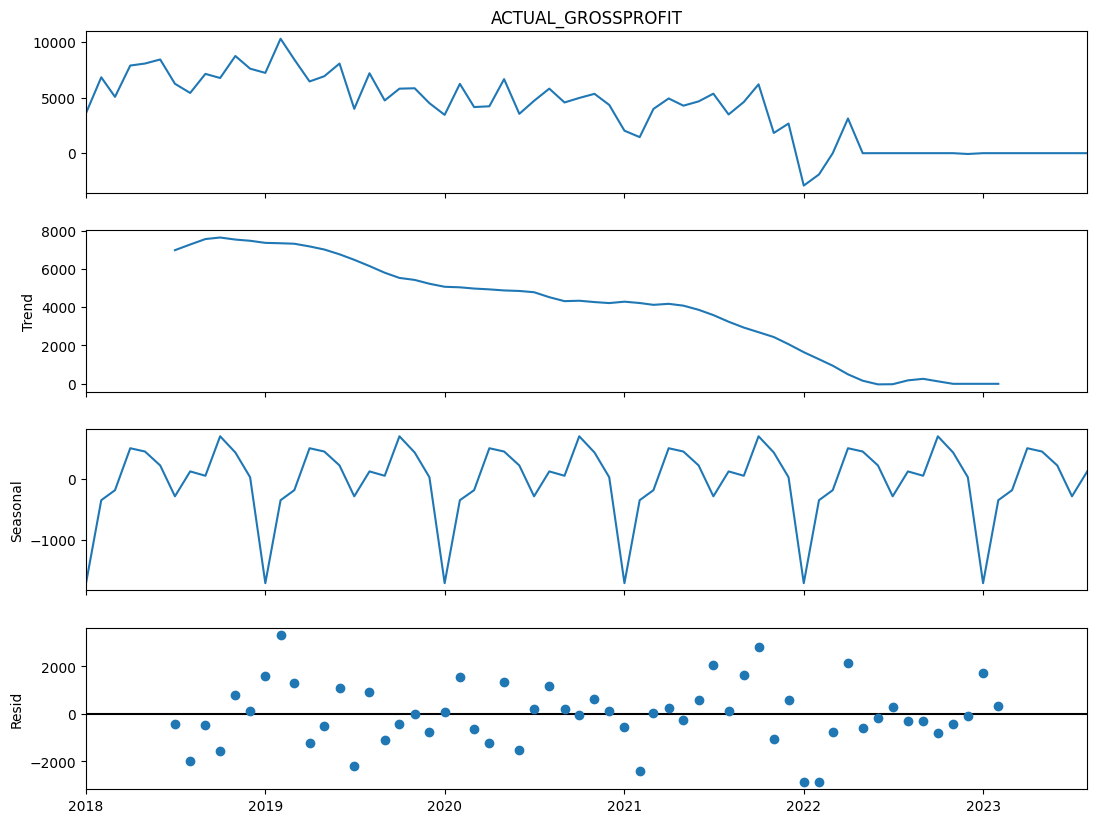

In [ ]:
df_janitorial_Raleigh = df[(df['LINEOFBUSINESS'] == 'Janitorial') & (df['PROFITCENTER'] == 'Raleigh ENC Legacy')]
df_janitorial_Raleigh = df_janitorial_Raleigh.sort_values(by = 'YR_MTH', ascending = True)

# Convert the timestamp column to datetime
df_janitorial_Raleigh['YR_MTH'] = pd.to_datetime(df_janitorial_Raleigh['YR_MTH'])

# Set the timestamp as the index
df_janitorial_Raleigh.set_index('YR_MTH', inplace=True)
result = seasonal_decompose(df_janitorial_Raleigh['ACTUAL_GROSSPROFIT'], model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)

Based on additive model we see that the time series has a strong downward trend and seasonal component. Residual is mostly random so most of the variance is explained by trend and seasonality

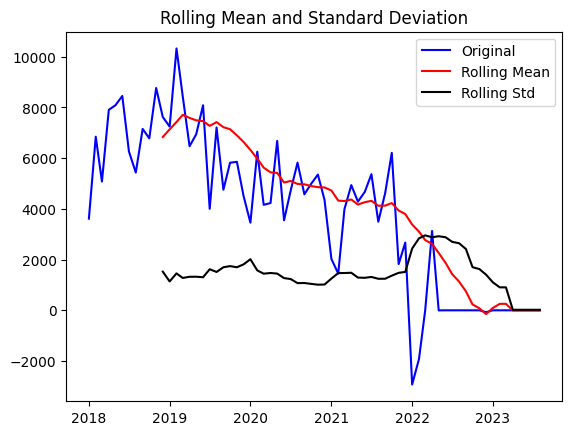

Results of Dickey Fuller test
Test Statistics                -1.074370
p-value                         0.725184
No. of lags used                2.000000
Number of observations used    65.000000
critical value (1%)            -3.535217
critical value (5%)            -2.907154
critical value (10%)           -2.591103
dtype: float64


In [ ]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Dickey Fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_janitorial_Raleigh['ACTUAL_GROSSPROFIT'])

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so. Based on the high p-value = 0.72 we observe that the time series is non stationary

In [ ]:
#print unique values for LOB
print("There are", df['LINEOFBUSINESS'].nunique(),"LOBs","\n",df['LINEOFBUSINESS'].unique())

There are 7 LOBs 
 ['Corporate Overhead' 'Facility Management' 'Janitorial' 'Landscaping'
 'Maintenance' 'Production Support' 'Specialty Services']


In [ ]:
#print unique values for PROFITCENTER
print("There are", df['PROFITCENTER'].nunique(),"profit centers", "\n", df['PROFITCENTER'].unique())

There are 56 profit centers 
 ['Corporate Overhead' 'Eastern Virginia' 'Alamance-Orange County'
 'Anderson University' 'Asheville'
 'Chapel Hill - Carrboro City NC Schools' 'Charleston - General'
 'Charleston County Schools Mt Pleasant'
 'Charleston County Schools West Ashley' 'Charlotte Central'
 'Charlotte General Manager' 'Charlotte North' 'Chattanooga'
 'Chester County' 'Columbia' 'Converse College' 'Greater Tennessee'
 'Greensboro - General' 'Greenwood County SC Schools'
 'Hall County GA Schools' 'High Point University'
 'Kershaw County School District' 'Lancaster County School District'
 "Lowe's" 'Middle TN' 'Nashville - General' 'North Greenville University'
 'Orange County Schools NC' 'Piedmont' 'RJR' 'Raleigh'
 'Raleigh ENC Legacy' 'Rock Hill' 'SC-East' 'SC-West' 'South Carolina'
 'Tennessee General Manager' 'Union County Schools SC'
 'Virginia Central and West' 'WS/FCS Schools' 'Wake Forest University'
 'West Virginia - General' 'Winston Salem - General' 'Winston Salem Major'

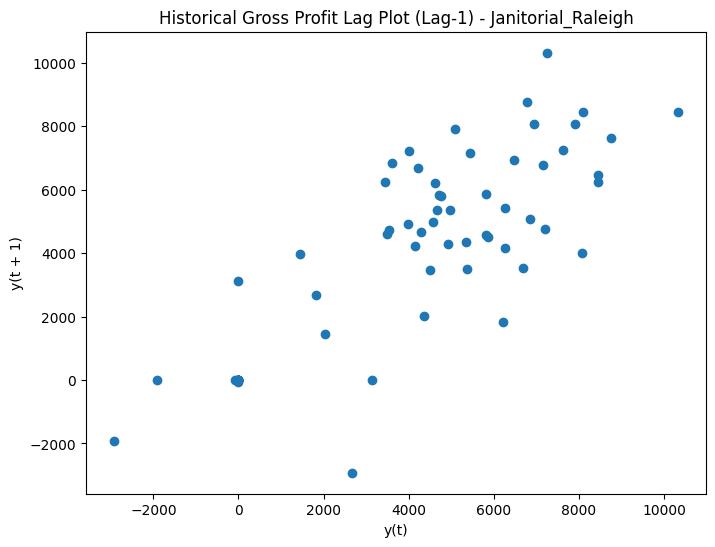

In [ ]:
#lag-1 plot for specific LOB and PROFITCENTER

plt.figure(figsize=(8, 6))

df_janitorial_Raleigh = df[(df['LINEOFBUSINESS'] == 'Janitorial') & (df['PROFITCENTER'] == 'Raleigh ENC Legacy')]
df_janitorial_Raleigh = df_janitorial_Raleigh.sort_values(by = 'YR_MTH', ascending = True)

lag_plot(df_janitorial_Raleigh['ACTUAL_GROSSPROFIT'], lag=1)  # Here, lag=1 means we're comparing each point to the previous point
plt.title('Historical Gross Profit Lag Plot (Lag-1) - Janitorial_Raleigh')
plt.show()

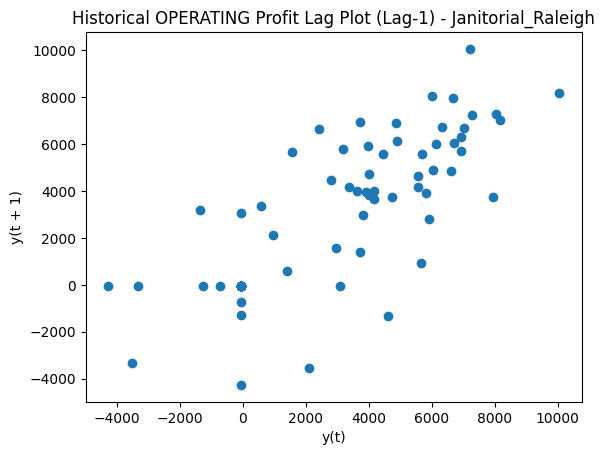

In [ ]:
lag_plot(df_janitorial_Raleigh['ACTUAL_OPERATINGPROFIT'], lag=1)  # Here, lag=1 means we're comparing each point to the previous point
plt.title('Historical OPERATING Profit Lag Plot (Lag-1) - Janitorial_Raleigh')
plt.show()

**Interpretation of lag plot (lag-1)**
- Obvious increasing trend from scatterplot for both gross profit and operating profit: strong autocorrelation expected
- Some presence of outliers but not severe. Most points generally fall in-line with increasing trend

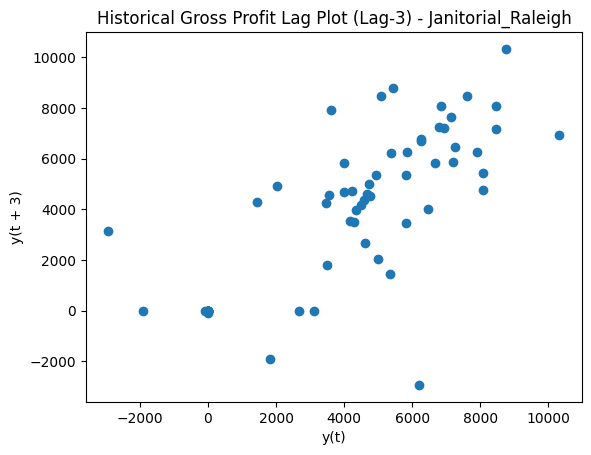

In [ ]:
#experimenting with other lags: seasonal
lag_plot(df_janitorial_Raleigh['ACTUAL_GROSSPROFIT'], lag=3)  # Here, lag=1 means we're comparing each point to the previous point
plt.title('Historical Gross Profit Lag Plot (Lag-3) - Janitorial_Raleigh')
plt.show()

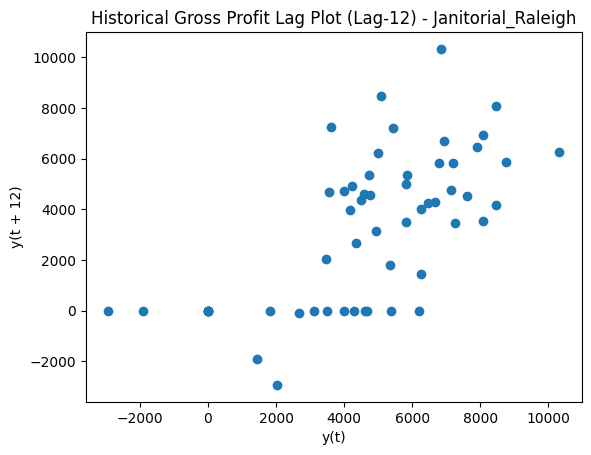

In [ ]:
#experimenting with other lags: annual
lag_plot(df_janitorial_Raleigh['ACTUAL_GROSSPROFIT'], lag=12)  # Here, lag=1 means we're comparing each point to the previous point
plt.title('Historical Gross Profit Lag Plot (Lag-12) - Janitorial_Raleigh')
plt.show()

**Observations for Lag-4 and Lag-12 Plots:**  autocorrelation appears weaker for lag-12 but positive trend is still observed

# Grid Search for Identifying Lagged Variables

In [ ]:
# # Data Split
# train_size = int(len(final_df) * 0.8)  # 80% for training, adjust as needed
# train_data = final_df[:train_size]
# test_data = final_df[train_size:]

In [ ]:
df_janitorial_Raleigh = final_df[(final_df['LINEOFBUSINESS'] == 'Janitorial') & (final_df['PROFITCENTER'] == 'Raleigh ENC Legacy')]
train_size = int(len(df_janitorial_Raleigh) * 0.8)
df_janitorial_Raleigh_train = df_janitorial_Raleigh[:train_size]
df_janitorial_Raleigh_train = df_janitorial_Raleigh_train.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_janitorial_Raleigh_train))
df_janitorial_Raleigh_test = df_janitorial_Raleigh[train_size:]
df_janitorial_Raleigh_test = df_janitorial_Raleigh_test.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_janitorial_Raleigh_test))

In [ ]:
df_maintenance_Highpoint = final_df[(final_df['LINEOFBUSINESS'] == 'Maintenance') & (final_df['PROFITCENTER'] == 'High Point University')]
train_size = int(len(df_maintenance_Highpoint) * 0.8)
df_maintenance_Highpoint_train = df_maintenance_Highpoint[:train_size]
df_maintenance_Highpoint_train = df_maintenance_Highpoint_train.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_maintenance_Highpoint_train))
df_maintenance_Highpoint_test = df_maintenance_Highpoint[train_size:]
df_maintenance_Highpoint_test = df_maintenance_Highpoint_test.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_maintenance_Highpoint_test))

In [ ]:
df_specialty_SC = final_df[(final_df['LINEOFBUSINESS'] == 'Specialty Services') & (final_df['PROFITCENTER'] == 'SC-East')]
train_size = int(len(df_specialty_SC) * 0.8)
df_specialty_SC_train = df_specialty_SC[:train_size]
df_specialty_SC_train = df_specialty_SC_train.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_specialty_SC_train))
df_specialty_SC_test = df_specialty_SC[train_size:]
df_specialty_SC_test = df_specialty_SC_test.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_specialty_SC_test))

In [10]:
#converting grid search into a function
def arima_grid_search(train, test):
    """
    Conduct a grid search for ARIMA parameters on the given data.

    Parameters:
    - data: DataFrame with time series data

    Returns:
    - Best ARIMA order based on AIC
    - Best AIC value
    - Test MSE for the selected ARIMA model
    """
    # Suppress warnings
    warnings.filterwarnings("ignore")

    # Assuming daily frequency (modify if needed)
    # train.index = pd.DatetimeIndex(train.index).to_period('D')
    # test.index = pd.DatetimeIndex(test.index).to_period('D')

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 6)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    best_aic = np.inf
    best_order = None

    for order in pdq:
        try:
            model = ARIMA(train, order=order)
            results = model.fit()

            # Compare AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order

        except:
            continue

    # Refit the model with the best order on the entire training set
    best_model_refitted = ARIMA(train, order=best_order).fit()

    # Forecasting on the test set
    forecast = best_model_refitted.forecast(steps=len(test))
    error = mean_squared_error(test, forecast)

    return best_order, best_aic, error


In [ ]:
#calling grid search function - trial 1

print("Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = gross profit", "\n")

train_1 = df_janitorial_Raleigh_train['ACTUAL_GROSSPROFIT']
test_1 = df_janitorial_Raleigh_test['ACTUAL_GROSSPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_1, test_1)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = gross profit 

Best ARIMA Order: (0, 5, 4)
Best AIC: 921.3487643119283
Test MSE: 24541854.591786325


In [ ]:
#calling grid search function - trial 2

print("Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = operating profit", "\n")

train_2 = df_janitorial_Raleigh_train['ACTUAL_OPERATINGPROFIT']
test_2 = df_janitorial_Raleigh_test['ACTUAL_OPERATINGPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_2, test_2)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = operating profit 

Best ARIMA Order: (3, 5, 3)
Best AIC: 14.0
Test MSE: 1.3691450264009394e+19


In [ ]:
#calling grid search function - trial 3

print("Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = revenue", "\n")

train_3 = df_janitorial_Raleigh_train['ACTUAL_REVENUE']
test_3 = df_janitorial_Raleigh_test['ACTUAL_REVENUE']

best_order, best_aic, test_mse = arima_grid_search(train_3, test_3)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Janitorial, branch = Raleigh ENC Legacy, metric = revenue 

Best ARIMA Order: (4, 0, 4)
Best AIC: 20.0
Test MSE: 385520851.61250246


In [ ]:
#calling grid search function - trial 4

print("Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = gross profit", "\n")

train_4 = df_maintenance_Highpoint_train['ACTUAL_GROSSPROFIT']
test_4 = df_maintenance_Highpoint_test['ACTUAL_GROSSPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_4, test_4)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = gross profit 

Best ARIMA Order: (4, 3, 4)
Best AIC: 1184.974188793505
Test MSE: 916256754.4972979


In [ ]:
#calling grid search function - trial 5

print("Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = operating profit", "\n")

train_5 = df_maintenance_Highpoint_train['ACTUAL_OPERATINGPROFIT']
test_5 = df_maintenance_Highpoint_test['ACTUAL_OPERATINGPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_5, test_5)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = operating profit 

Best ARIMA Order: (2, 4, 3)
Best AIC: 36.85581334899082
Test MSE: 2.44033698121765e+20


In [ ]:
#calling grid search function - trial 6

print("Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = revenue", "\n")

train_6 = df_maintenance_Highpoint_train['ACTUAL_REVENUE']
test_6 = df_maintenance_Highpoint_test['ACTUAL_REVENUE']

best_order, best_aic, test_mse = arima_grid_search(train_6, test_6)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Maintenance, branch = High Point, metric = revenue 

Best ARIMA Order: (5, 5, 5)
Best AIC: 1182.2421463281669
Test MSE: 8056419058.500137


In [ ]:
#calling grid search function - trial 7

print("Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = gross profit", "\n")

train_7 = df_specialty_SC_train['ACTUAL_GROSSPROFIT']
test_7 = df_specialty_SC_test['ACTUAL_GROSSPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_7, test_7)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = gross profit 

Best ARIMA Order: (2, 5, 4)
Best AIC: 842.3004099657356
Test MSE: 1433171740.8510072


In [ ]:
#calling grid search function - trial 8

print("Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = operating profit", "\n")

train_8 = df_specialty_SC_train['ACTUAL_OPERATINGPROFIT']
test_8 = df_specialty_SC_test['ACTUAL_OPERATINGPROFIT']

best_order, best_aic, test_mse = arima_grid_search(train_8, test_8)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = operating profit 

Best ARIMA Order: (2, 4, 3)
Best AIC: 848.0289502928399
Test MSE: 962732160.3299035


In [ ]:
#calling grid search function - trial 9

print("Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = revenue", "\n")

train_9 = df_specialty_SC_train['ACTUAL_REVENUE']
test_9 = df_specialty_SC_test['ACTUAL_REVENUE']

best_order, best_aic, test_mse = arima_grid_search(train_9, test_9)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Specialty Services, branch = SC-East, metric = revenue 

Best ARIMA Order: (2, 5, 3)
Best AIC: 900.5591719571877
Test MSE: 4964870911.065095


# Grid Search on LOB Level

In [11]:
#get list of LOBs
LOBs = final_df_lob['LINEOFBUSINESS'].unique()
LOBs = list(filter(lambda item: item is not None, LOBs))

for LOB in LOBs:
  print(LOB)

Corporate Overhead
Facility Management
Janitorial
Landscaping
Maintenance
Production Support
Specialty Services


In [12]:
# Convert the timestamp column to datetime
final_df_lob['YR_MTH'] = pd.to_datetime(final_df_lob['YR_MTH'])
final_df_lob.head()

,YR_MTH,LINEOFBUSINESS,ACTUAL_GROSSPROFIT,2023 FS_GrossProfit,WORKING_GROSSPROFIT,ACTUAL_REVENUE,2023 FS_Revenue,WORKING_REVENUE,ACTUAL_OPERATINGPROFIT,2023 FS_OperatingProfit,WORKING_OPERATINGPROFIT
0,2018-01-01,Corporate Overhead,19704.35,0.0,0.0,0.0,0.0,0.0,-1066529.32,0.0,0.0
1,2018-02-01,Corporate Overhead,20906.34,0.0,0.0,0.0,0.0,0.0,-837109.31,0.0,0.0
2,2018-03-01,Corporate Overhead,5225.36,0.0,0.0,0.0,0.0,0.0,-960384.14,0.0,0.0
3,2018-04-01,Corporate Overhead,4825.31,0.0,0.0,0.0,0.0,0.0,-893573.68,0.0,0.0
4,2018-05-01,Corporate Overhead,7517.00,0.0,0.0,0.0,0.0,0.0,-994373.24,0.0,0.0


In [13]:
#train-test split to be done after LOB isolation
# # Data Split
# lob_train_size = int(len(df_lob) * 0.8)  # 80% for training, adjust as needed
# lob_train_data = df_lob[:lob_train_size]
# lob_test_data = df_lob[lob_train_size:]

In [14]:
#try to 1 LOB before looping
df_janitorial = final_df_lob[final_df_lob['LINEOFBUSINESS'] == "Janitorial"]
lob_train_size = int(len(df_janitorial) * 0.8)
df_janitorial_train = df_janitorial[:lob_train_size]
df_janitorial_train = df_janitorial_train.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_janitorial_train))
df_janitorial_test = df_janitorial[lob_train_size:]
df_janitorial_test = df_janitorial_test.sort_values(by = 'YR_MTH', ascending = True)
#print(len(df_janitorial_test))

In [15]:
print("Optimal ARIMA model for LOB = Janitorial, metric = revenue", "\n")

train_lob = df_janitorial_train['ACTUAL_REVENUE']
test_lob = df_janitorial_test['ACTUAL_REVENUE']

best_order, best_aic, test_mse = arima_grid_search(train_lob, test_lob)

print('Best ARIMA Order:', best_order)
print('Best AIC:', best_aic)
print('Test MSE:', test_mse)

Optimal ARIMA model for LOB = Janitorial, metric = revenue 

Best ARIMA Order: (5, 5, 2)
Best AIC: 16.0
Test MSE: 1.4406608314002003e+28


In [16]:
#creating empty dataframe for output
grid_search = pd.DataFrame(columns = ['ACTUAL_GROSSPROFIT', 'ACTUAL_OPERATINGPROFIT', 'ACTUAL_REVENUE'])

In [17]:
for LOB in LOBs:

  #using temporary dataframe for tracking output from each loop
  tempt = pd.DataFrame(columns = ['ACTUAL_GROSSPROFIT', 'ACTUAL_OPERATINGPROFIT', 'ACTUAL_REVENUE'])

  #data extraction for specific LOB with train-test split and sorting

  df_lob = final_df_lob[final_df_lob['LINEOFBUSINESS'] == LOB]
  lob_train_size = int(len(df_lob) * 0.8)
  df_lob_train = df_lob[:lob_train_size]
  df_lob_train = df_lob_train.sort_values(by = 'YR_MTH', ascending = True)
  df_lob_test = df_lob[lob_train_size:]
  df_lob_test = df_lob_test.sort_values(by = 'YR_MTH', ascending = True)


  #grid search for gross profit

  print("\n")
  print("Optimal ARIMA model for LOB =", LOB, ", metric = gross profit", "\n", "\n")

  train_lob_grossprofit = df_lob_train['ACTUAL_GROSSPROFIT']
  test_lob_grossprofit = df_lob_train['ACTUAL_GROSSPROFIT']

  best_order, best_aic, test_mse = arima_grid_search(train_lob_grossprofit, test_lob_grossprofit)

  print('Best ARIMA Order:', best_order)
  print('Best AIC:', best_aic)
  print('Test MSE:', test_mse)

  tempt['ACTUAL_GROSSPROFIT'] = [best_order]

  #grid search for operating profit

  print("\n")
  print("Optimal ARIMA model for LOB =", LOB, ", metric = operating profit", "\n")

  train_lob_operatingprofit = df_lob_train['ACTUAL_OPERATINGPROFIT']
  test_lob_operatingprofit = df_lob_train['ACTUAL_OPERATINGPROFIT']

  best_order, best_aic, test_mse = arima_grid_search(train_lob_operatingprofit, test_lob_operatingprofit)

  print('Best ARIMA Order:', best_order)
  print('Best AIC:', best_aic)
  print('Test MSE:', test_mse)

  tempt['ACTUAL_OPERATINGPROFIT'] = [best_order]

  #grid search for revenue
  print("\n")
  print("Optimal ARIMA model for LOB =", LOB, ", metric = revenue", "\n")

  train_lob_revenue = df_lob_train['ACTUAL_REVENUE']
  test_lob_revenue = df_lob_train['ACTUAL_REVENUE']

  best_order, best_aic, test_mse = arima_grid_search(train_lob_revenue, test_lob_revenue)

  print('Best ARIMA Order:', best_order)
  print('Best AIC:', best_aic)
  print('Test MSE:', test_mse)

  tempt['ACTUAL_REVENUE'] = [best_order]

  #appending tempt dataframe to output file
  grid_search = pd.concat([grid_search, tempt], ignore_index = True)



Optimal ARIMA model for LOB = Corporate Overhead , metric = gross profit 
 

Best ARIMA Order: (0, 3, 3)
Best AIC: 1165.553380456265
Test MSE: 367003383.9357516


Optimal ARIMA model for LOB = Corporate Overhead , metric = operating profit 

Best ARIMA Order: (5, 3, 2)
Best AIC: 16.0
Test MSE: 2.773771189629538e+25


Optimal ARIMA model for LOB = Corporate Overhead , metric = revenue 

Best ARIMA Order: (0, 1, 1)
Best AIC: -1337.2434885233067
Test MSE: 0.0


Optimal ARIMA model for LOB = Facility Management , metric = gross profit 
 

Best ARIMA Order: (5, 5, 5)
Best AIC: 918.395813030056
Test MSE: 585388335398.759


Optimal ARIMA model for LOB = Facility Management , metric = operating profit 

Best ARIMA Order: (5, 4, 2)
Best AIC: 16.0
Test MSE: 4.2097076252255597e+17


Optimal ARIMA model for LOB = Facility Management , metric = revenue 

Best ARIMA Order: (2, 5, 4)
Best AIC: 14.0
Test MSE: 1180528532.5255172


Optimal ARIMA model for LOB = Janitorial , metric = gross profit 
 

B

In [18]:
#print grid_search dataframe for output
grid_search['LOB'] = LOBs
grid_search

# Test: select one specific order
# display(grid_search[grid_search["LOB"]=="Corporate Overhead"])


,ACTUAL_GROSSPROFIT,ACTUAL_OPERATINGPROFIT,ACTUAL_REVENUE,LOB
0,"(0, 3, 3)","(5, 3, 2)","(0, 1, 1)",Corporate Overhead
1,"(5, 5, 5)","(5, 4, 2)","(2, 5, 4)",Facility Management
2,"(2, 5, 3)","(5, 5, 2)","(5, 5, 2)",Janitorial
3,"(5, 4, 2)","(4, 4, 2)","(2, 5, 5)",Landscaping
4,"(4, 3, 2)","(4, 3, 2)","(4, 5, 5)",Maintenance
5,"(5, 5, 3)","(4, 5, 2)","(4, 5, 3)",Production Support
6,"(2, 5, 4)","(2, 5, 4)","(4, 5, 3)",Specialty Services


# Model Fitting by combination

In [19]:
from statsmodels.tsa.statespace.tools import prepare_trend_data
# Function to train ARIMA model for a specific combination
def train_arima_model(data, best_order):
  # Suppress warnings
  warnings.filterwarnings("ignore")
  # print(best_order)
  # try:
  model = ARIMA(data, order=best_order)
  model.initialize_approximate_diffuse()
  model_fit = model.fit()
  return model_fit
  # except:
  #   return "ARIMA Error..."

# define formula to check stationarity
def check_stationarity(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    adf_statistic = result[0]
    p_value = result[1]

    if p_value > 0.05:
        # Take first-order difference to make data stationary
        differenced_series = series.diff().dropna()

        # Check stationarity of differenced data
        check_stationarity(differenced_series)

# Function to append all prediction results to a dataframe
def append_pred_output(pred_df, yr_mth, line_of_business, profit_centre, forecast_type, pred_output):
    pred_data = {
                'YR_MTH': yr_mth,                             # Need to rename to YR_MTH
                'LINEOFBUSINESS': line_of_business,
                'PROFITCENTER': profit_centre,
                "ACTUAL_GROSSPROFIT": np.nan,
                "ACTUAL_OPERATINGPROFIT": np.nan,
                "ACTUAL_REVENUE": np.nan,
                forecast_type: pred_output
                }
    row = pd.Series(pred_data)

    if (len(pred_df) == 0):
      pred_df = pred_df.append(row, ignore_index=True)
      # display(pred_df.tail())

      return pred_df

    df1 = pred_df.loc[(pred_df['LINEOFBUSINESS'] == line_of_business) & (pred_df['PROFITCENTER'] == profit_centre) & (pred_df['YR_MTH'] == yr_mth)].copy()
    if (len(df1) == 0):
      pred_df = pred_df.append(row, ignore_index=True)
    else:
      df1.loc[:, forecast_type] = pred_output
      pred_df.loc[df1.index] = df1

    # display(pred_df.tail())

    return pred_df



In [20]:
# Create all possible combinations of Line_of_business and Profit_centre
display(final_df.head())
display(final_df.tail())
forecast_type = ["ACTUAL_GROSSPROFIT", "ACTUAL_OPERATINGPROFIT", "ACTUAL_REVENUE"]
combinations = list(itertools.product(final_df['LINEOFBUSINESS'].unique(), final_df['PROFITCENTER'].unique(), forecast_type))

# For testing, limit to 6 combinations
combinations = combinations[:6]
display(combinations)

# Debug ('Facility Management', 'Eastern Virginia', 'ACTUAL_GROSSPROFIT')
# display(final_df[(final_df['LINEOFBUSINESS'] == 'Facility Management') & (final_df['PROFITCENTER'] == 'Eastern Virginia')]['ACTUAL_GROSSPROFIT'])

# # Debug YR_MTH
# curr_yr_mth = final_df.iloc[-1]['YR_MTH']
# curr_yr_mth = pd.to_datetime(curr_yr_mth)
# print(curr_yr_mth)
# # Calculate the timestamp for the first day of the next month
# next_month = curr_yr_mth.replace(day=1, month=curr_yr_mth.month + 1)

# # Handle the case where the current month is December
# if curr_yr_mth.month == 12:
#     next_month = next_month.replace(year=curr_yr_mth.year + 1, month=1)

# # Print the result
# print(next_month)



,YR_MTH,LINEOFBUSINESS,PROFITCENTER,ACTUAL_GROSSPROFIT,2023 FS_GrossProfit,WORKING_GROSSPROFIT,ACTUAL_REVENUE,2023 FS_Revenue,WORKING_REVENUE,ACTUAL_OPERATINGPROFIT,2023 FS_OperatingProfit,WORKING_OPERATINGPROFIT
0,2018-01,Corporate Overhead,Corporate Overhead,19704.35,0.0,0.0,0.0,0.0,0.0,-1066529.32,0.0,0.0
1,2018-02,Corporate Overhead,Corporate Overhead,20906.34,0.0,0.0,0.0,0.0,0.0,-837109.31,0.0,0.0
2,2018-03,Corporate Overhead,Corporate Overhead,5225.36,0.0,0.0,0.0,0.0,0.0,-960384.14,0.0,0.0
3,2018-04,Corporate Overhead,Corporate Overhead,4825.31,0.0,0.0,0.0,0.0,0.0,-893573.68,0.0,0.0
4,2018-05,Corporate Overhead,Corporate Overhead,7517.00,0.0,0.0,0.0,0.0,0.0,-994373.24,0.0,0.0


,YR_MTH,LINEOFBUSINESS,PROFITCENTER,ACTUAL_GROSSPROFIT,2023 FS_GrossProfit,WORKING_GROSSPROFIT,ACTUAL_REVENUE,2023 FS_Revenue,WORKING_REVENUE,ACTUAL_OPERATINGPROFIT,2023 FS_OperatingProfit,WORKING_OPERATINGPROFIT
5213,2023-04,Specialty Services,Winston Salem - General,0.00,2079.97,0.0,0.00,3021.02,0.0,0.00,2079.97,0.0
5214,2023-05,Specialty Services,Winston Salem - General,308.35,462.26,0.0,575.00,1000.00,0.0,308.35,462.26,0.0
5215,2023-06,Specialty Services,Winston Salem - General,297.95,0.00,0.0,550.00,0.00,0.0,297.95,0.00,0.0
5216,2023-07,Specialty Services,Winston Salem - General,708.05,0.00,0.0,2437.45,0.00,0.0,708.05,0.00,0.0
5217,2023-08,Specialty Services,Winston Salem - General,193.50,462.26,0.0,900.00,1000.00,0.0,193.50,462.26,0.0


[('Corporate Overhead', 'Corporate Overhead', 'ACTUAL_GROSSPROFIT'),
 ('Corporate Overhead', 'Corporate Overhead', 'ACTUAL_OPERATINGPROFIT'),
 ('Corporate Overhead', 'Corporate Overhead', 'ACTUAL_REVENUE'),
 ('Corporate Overhead', 'Eastern Virginia', 'ACTUAL_GROSSPROFIT'),
 ('Corporate Overhead', 'Eastern Virginia', 'ACTUAL_OPERATINGPROFIT'),
 ('Corporate Overhead', 'Eastern Virginia', 'ACTUAL_REVENUE')]

In [21]:
# Initialize a dictionary to store forecasted values for each combination
forecasted_values_dict = {}

# Create a dataframe to store prediction and forecast results
pred_df = pd.DataFrame()

# Loop through each combination
for combo in combinations:
    # line_of_business, profit_centre, forecast_type = ('Facility Management', 'Eastern Virginia', 'ACTUAL_GROSSPROFIT')
    line_of_business, profit_centre, forecast_type = combo
    # print(combo)

    # Filter data for the specific combination
    combo_data = final_df[(final_df['LINEOFBUSINESS'] == line_of_business) & (final_df['PROFITCENTER'] == profit_centre)]
    # combo_data = final_df[(final_df['LINEOFBUSINESS'] == 'Facility Management') & (final_df['PROFITCENTER'] == 'Eastern Virginia')]
    combo_data['YR_MTH'] = pd.to_datetime(combo_data['YR_MTH'])
    combo_data_ts = combo_data[['YR_MTH', forecast_type]].sort_values(by='YR_MTH')
    if len(combo_data_ts) < 60: continue # need to double check on dataset - remove this line will hit error
    # display(combo_data_ts.head())

    # Split data
    combo_data_train_size = int(len(combo_data_ts) * 0.8)  # 80% for training, adjust as needed
    combo_data_train = combo_data_ts[:combo_data_train_size]
    combo_data_test = combo_data_ts[combo_data_train_size:]
    # display(combo_data_test.head())

    # Check for stationarity and apply differencing if needed
    # check_stationarity(combo_data['column name'])

    # Identify ARIMA order (p, d, q) -> pre-determined
    # best_order, best_aic, test_mse = arima_grid_search(combo_data_train, combo_data_test)
    best_order = grid_search[grid_search["LOB"]==line_of_business][forecast_type].to_list()
    # print(best_order[0])

    predictions = list()
    # walk-forward validation
    for t in range(len(combo_data_test)):
    # for t in range(5):
      combo_model = train_arima_model(combo_data_train[forecast_type], best_order[0])
      output = combo_model.forecast()
      yhat = output
      # print(yhat.values[0])
      predictions.append(yhat)
      obs = combo_data_test.iloc[t]
      combo_data_train = combo_data_train.append(obs)
      # display(combo_data_train.tail())
      # print('predicted=%f, expected=%f' % (yhat, obs[forecast_type]))
      # Append prediction output into a dataframe
      pred_df = append_pred_output(pred_df, combo_data_test.iloc[t]['YR_MTH'], line_of_business, profit_centre, forecast_type, yhat.values[0])

    # evaluate forecasts
    rmse = sqrt(mean_squared_error(combo_data_test[forecast_type], predictions))
    print('Test RMSE: %.3f' % rmse)

    # Forecast future revenue - the next 12 periods
    forecast_periods = 12
    forecasted_values = combo_model.get_forecast(steps=forecast_periods)
    # Extract forecasted values and confidence intervals
    forecast_mean = forecasted_values.predicted_mean
    forecast_ci = forecasted_values.conf_int()

    curr_yr_mth = combo_data_test.iloc[-1]['YR_MTH']
    for f in range(forecast_periods):
      if curr_yr_mth.month == 12:
          curr_yr_mth = curr_yr_mth.replace(year=curr_yr_mth.year + 1, month=1)
      else:
          curr_yr_mth = curr_yr_mth.replace(day=1, month=curr_yr_mth.month + 1)
      # print(forecast_mean.values[f])
      pred_df = append_pred_output(pred_df, curr_yr_mth, line_of_business, profit_centre, forecast_type, forecast_mean.values[f])


    # print("Forecasted Values for the Next 12 Periods:")
    # print(forecast_mean)
    # print("\nForecasted Confidence Intervals for the Next 12 Periods:")
    # print(forecast_ci)

    # Store forecasted values and other information in the dictionary
    # forecasted_values_dict[combo] = {
    #     'line_of_business': line_of_business,
    #     'profit_centre': profit_centre,
    #     'forecast_type': forecast_type,
    #     'combo_model': combo_model,
    #     'rmse': rmse,
    #     'forecasted_values': forecast_mean
    #     # Add other relevant information here
    # }

Test RMSE: 28446.757
Test RMSE: 342304.461
Test RMSE: 0.000


In [22]:
forecasted_values_dict

# forecasted_values_dict[('Corporate Overhead', 'Corporate Overhead', 'ACTUAL_GROSSPROFIT')]['forecasted_values']

{}

# Combine Prediction Results with Final Dataframe

In [29]:
# Rename Prediction Dataframe
pred_df = pred_df.rename(columns={
    "ACTUAL_GROSSPROFIT": "PRED_GROSSPROFIT",
    "ACTUAL_OPERATINGPROFIT": "PRED_OPERATINGPROFIT",
    "ACTUAL_REVENUE": "PRED_REVENUE"
})
display(pred_df.tail())

final_pred_df = final_df[["YR_MTH", "LINEOFBUSINESS", "PROFITCENTER", "ACTUAL_GROSSPROFIT", "ACTUAL_OPERATINGPROFIT", "ACTUAL_REVENUE"]]
final_pred_df['YR_MTH'] = pd.to_datetime(final_pred_df['YR_MTH'])
display(final_pred_df.tail())

final_pred_df.merge(pred_df, how='outer', on=["YR_MTH", "LINEOFBUSINESS", "PROFITCENTER"])

,YR_MTH,LINEOFBUSINESS,PROFITCENTER,PRED_GROSSPROFIT,PRED_OPERATINGPROFIT,PRED_REVENUE
21,2024-04-01,Corporate Overhead,Corporate Overhead,-26441.683101,-2.305449e+06,0.0
22,2024-05-01,Corporate Overhead,Corporate Overhead,-33709.331359,-2.354071e+06,0.0
23,2024-06-01,Corporate Overhead,Corporate Overhead,-41351.149642,-2.371642e+06,0.0
24,2024-07-01,Corporate Overhead,Corporate Overhead,-49367.137949,-2.445609e+06,0.0
25,2024-08-01,Corporate Overhead,Corporate Overhead,-57757.296281,-2.454477e+06,0.0


,YR_MTH,LINEOFBUSINESS,PROFITCENTER,ACTUAL_GROSSPROFIT,ACTUAL_OPERATINGPROFIT,ACTUAL_REVENUE
5213,2023-04-01,Specialty Services,Winston Salem - General,0.00,0.00,0.00
5214,2023-05-01,Specialty Services,Winston Salem - General,308.35,308.35,575.00
5215,2023-06-01,Specialty Services,Winston Salem - General,297.95,297.95,550.00
5216,2023-07-01,Specialty Services,Winston Salem - General,708.05,708.05,2437.45
5217,2023-08-01,Specialty Services,Winston Salem - General,193.50,193.50,900.00


,YR_MTH,LINEOFBUSINESS,PROFITCENTER,ACTUAL_GROSSPROFIT,ACTUAL_OPERATINGPROFIT,ACTUAL_REVENUE,PRED_GROSSPROFIT,PRED_OPERATINGPROFIT,PRED_REVENUE
0,2018-01-01,Corporate Overhead,Corporate Overhead,19704.35,-1066529.32,0.0,NaN,NaN,NaN
1,2018-02-01,Corporate Overhead,Corporate Overhead,20906.34,-837109.31,0.0,NaN,NaN,NaN
2,2018-03-01,Corporate Overhead,Corporate Overhead,5225.36,-960384.14,0.0,NaN,NaN,NaN
3,2018-04-01,Corporate Overhead,Corporate Overhead,4825.31,-893573.68,0.0,NaN,NaN,NaN
4,2018-05-01,Corporate Overhead,Corporate Overhead,7517.00,-994373.24,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5225,2024-04-01,Corporate Overhead,Corporate Overhead,NaN,NaN,NaN,-26441.683101,-2.305449e+06,0.0
5226,2024-05-01,Corporate Overhead,Corporate Overhead,NaN,NaN,NaN,-33709.331359,-2.354071e+06,0.0
5227,2024-06-01,Corporate Overhead,Corporate Overhead,NaN,NaN,NaN,-41351.149642,-2.371642e+06,0.0
5228,2024-07-01,Corporate Overhead,Corporate Overhead,NaN,NaN,NaN,-49367.137949,-2.445609e+06,0.0
